In [ ]:
import pandas as pd
!pip install Bio
from Bio import SeqIO
from dataclasses import dataclass
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
import gffutils
import numpy as np

### Load GFF3

In [ ]:
# Load gff3
# gff3 is the annotation file that contains seqid (chromosome id), type (including genes, transcript, exons), start and end position,
# and strand information + (forward), -(reverse)

gff3_file_path = 'chr20.gff3'
data = []
with open(gff3_file_path, 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        parts = line.strip().split('\t')
        if len(parts) == 9:
            record = {
                'seqid': parts[0],
                'source': parts[1],
                'type': parts[2],
                'start': int(parts[3]),
                'end': int(parts[4]),
                'score': parts[5],
                'strand': parts[6],
                'phase': parts[7],
                'attributes': parts[8]
            }
            data.append(record)
df = pd.DataFrame(data)

In [ ]:
print(df.head())

   seqid  source        type  start    end score strand phase  \
0  chr20  HAVANA        gene  87250  97094     .      +     .   
1  chr20  HAVANA  transcript  87250  97094     .      +     .   
2  chr20  HAVANA        exon  87250  87359     .      +     .   
3  chr20  HAVANA  transcript  87672  97094     .      +     .   
4  chr20  HAVANA        exon  87672  87767     .      +     .   

                                          attributes  
0  ID=ENSG00000178591.7;gene_id=ENSG00000178591.7...  
1  ID=ENST00000608838.1;Parent=ENSG00000178591.7;...  
2  ID=exon:ENST00000608838.1:1;Parent=ENST0000060...  
3  ID=ENST00000382410.3;Parent=ENSG00000178591.7;...  
4  ID=exon:ENST00000382410.3:1;Parent=ENST0000038...  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
exon_df = df[df['type'] == 'exon']

exon_df['Parent'] = exon_df['attributes'].apply(lambda x: x.split('Parent=')[1].split(';')[0])

# Group by Parent
intron_counts = exon_df.groupby('Parent').size().reset_index(name='count')
intron_counts['intron_count'] = intron_counts['count'] - 1

# intron_counts contains the number of introns for each Parent (transcript or gene)
print(intron_counts[['Parent', 'intron_count']])

                 Parent  intron_count
0     ENST00000023939.8             9
1     ENST00000045083.6            21
2     ENST00000064571.3             2
3     ENST00000170150.4            15
4     ENST00000190983.5             3
...                 ...           ...
5565  ENST00000684519.1            17
5566  ENST00000684628.1             1
5567  ENST00000684644.1             7
5568  ENST00000684708.1             6
5569  ENST00000684761.1             9

[5570 rows x 2 columns]


<ipython-input-34-c1e77b5df993>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exon_df['Parent'] = exon_df['attributes'].apply(lambda x: x.split('Parent=')[1].split(';')[0])


In [ ]:
intron_counts['intron_count'].sum()

14932

type
False    36963
True     34275
Name: count, dtype: int64


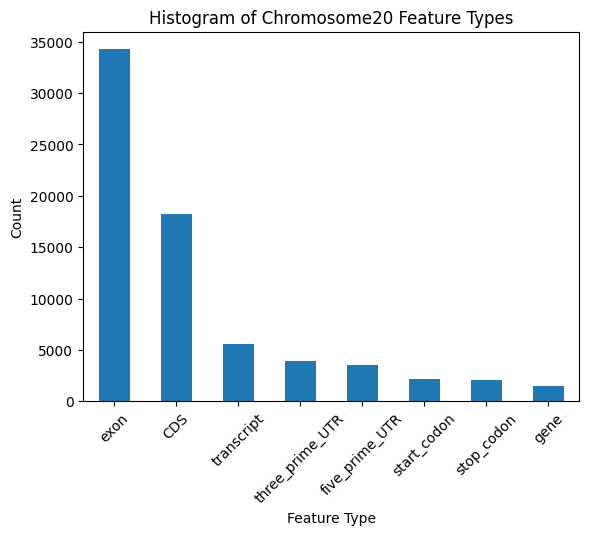

In [ ]:
import matplotlib.pyplot as plt
type_counts = df['type'].value_counts()
print((df['type']=='exon').value_counts())
# Plot a histogram
type_counts.plot(kind='bar')
plt.title('Histogram of Chromosome20 Feature Types')
plt.xlabel('Feature Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df

,seqid,source,type,start,end,score,strand,phase,attributes
0,chr20,HAVANA,gene,87250,97094,.,+,.,ID=ENSG00000178591.7;gene_id=ENSG00000178591.7...
1,chr20,HAVANA,transcript,87250,97094,.,+,.,ID=ENST00000608838.1;Parent=ENSG00000178591.7;...
2,chr20,HAVANA,exon,87250,87359,.,+,.,ID=exon:ENST00000608838.1:1;Parent=ENST0000060...
3,chr20,HAVANA,transcript,87672,97094,.,+,.,ID=ENST00000382410.3;Parent=ENSG00000178591.7;...
4,chr20,HAVANA,exon,87672,87767,.,+,.,ID=exon:ENST00000382410.3:1;Parent=ENST0000038...
...,...,...,...,...,...,...,...,...,...
71233,chr20,HAVANA,exon,64311267,64311371,.,+,.,ID=exon:ENST00000425473.1:2;Parent=ENST0000042...
71234,chr20,HAVANA,exon,64312728,64313132,.,+,.,ID=exon:ENST00000425473.1:3;Parent=ENST0000042...
71235,chr20,HAVANA,gene,64327418,64327972,.,-,.,ID=ENSG00000274727.1;gene_id=ENSG00000274727.1...
71236,chr20,HAVANA,transcript,64327418,64327972,.,-,.,ID=ENST00000620521.1;Parent=ENSG00000274727.1;...


In [ ]:
#fasta file path
fasta_file = 'chr20.fa'

In [ ]:
# Read the FASTA file (sequencing file) and store sequences in a dictionary for quick access
fasta_file = 'chr20.fa'
chromosome_sequence = next(SeqIO.parse(fasta_file, "fasta")).seq

### Extract Exons Sequences

In [ ]:
df_exons = df[df['type'] == 'exon']

In [ ]:
chromosome_seq_dict = SeqIO.to_dict(SeqIO.parse("chr20.fa", "fasta"))
chr20_seq = chromosome_seq_dict['chr20'].seq

In [ ]:
exon_sequences = []
for _, exon in df_exons.iterrows():
    start, end = exon['start'] - 1, exon['end']
    exon_seq = chr20_seq[start:end]
    exon_id = exon['attributes'].split(';')[0].split('=')[1]
    exon_sequences.append((exon_id, str(exon_seq)))

for exon_id, seq in exon_sequences:
    print(f"{exon_id}: {seq}")

In [ ]:
print(len(exon_sequences))

34275


In [ ]:
# Save the Exon to fasta
exon_seq_records = [SeqRecord(Seq(seq), id=exon_id, description="") for exon_id, seq in exon_sequences]
SeqIO.write(exon_seq_records, "chr20_exons.fa", "fasta")
print(f"Saved {len(exon_seq_records)} exon sequences to chr20_exons.fa")


Saved 34275 exon sequences to chr20_exons.fa


### Extract Non-Exon Sequences

In [ ]:
seq = chr20_seq
df_exons_sorted = df_exons.sort_values(by=['start'])
prev_end = 0
non_exon_sequences = []

for _, row in df_exons_sorted.iterrows():
    start, end = row['start'] - 1, row['end']
    if prev_end < start:
        non_exon_seq = chr20_seq[prev_end:start]
        non_exon_id = f"non_exon_{prev_end+1}_{start}"
        non_exon_sequences.append((non_exon_id, str(non_exon_seq)))
    prev_end = end

if prev_end < len(chr20_seq):
    non_exon_seq = chr20_seq[prev_end:]
    non_exon_id = f"non_exon_{prev_end+1}_end"
    non_exon_sequences.append((non_exon_id, str(non_exon_seq)))

non_exon_seq_records = [SeqRecord(Seq(seq), id=id, description="") for id, seq in non_exon_sequences]
SeqIO.write(non_exon_seq_records, "chr20_non_exons.fa", "fasta")

print(f"Saved {len(non_exon_seq_records)} non-exon sequences.")


Saved 8249 non-exon sequences.


### One Hot Encode

In [ ]:
def one_hot_encode_seq(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(nuc, [0, 0, 0, 0]) for nuc in seq.upper()])

# Load sequences from FASTA file and one-hot encode them
fasta_file = '/content/chr20_exons.fa'

encoded_seqs = []
seq_lengths = []

for record in SeqIO.parse(fasta_file, 'fasta'):
    seq = str(record.seq)
    encoded_seq = one_hot_encode_seq(seq)
    encoded_seqs.append(encoded_seq)
    seq_lengths.append(len(seq))

for i, encoded_seq in enumerate(encoded_seqs):
    print(f"Shape of encoded sequence {i}: {encoded_seq.shape}")

print(f"Sequence lengths: {seq_lengths}")

In [ ]:
print(max(seq_lengths))
print(min(seq_lengths))

11579
1


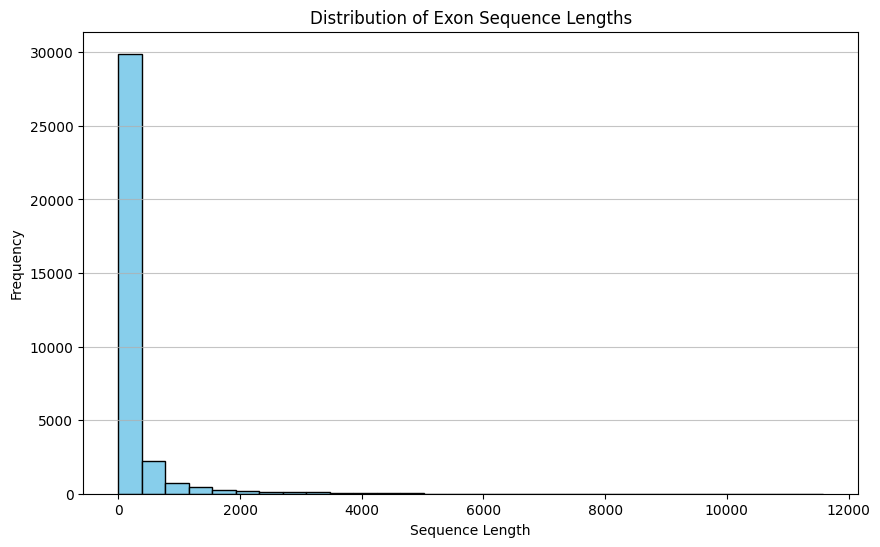

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins =30, color='skyblue', edgecolor='black')
plt.title('Distribution of Exon Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Showing the histogram
plt.show()

In [ ]:
fasta_file = '//content/chr20_non_exons.fa'

encoded_seqs = []
seq_lengths = []

for record in SeqIO.parse(fasta_file, 'fasta'):
    seq = str(record.seq)
    encoded_seq = one_hot_encode_seq(seq)
    encoded_seqs.append(encoded_seq)
    seq_lengths.append(len(seq))

for i, encoded_seq in enumerate(encoded_seqs):
    print(f"Shape of encoded sequence {i}: {encoded_seq.shape}")

print(f"Sequence lengths: {seq_lengths}")

流式输出内容被截断，只能显示最后 5000 行内容。
Shape of encoded sequence 3250: (7668, 4)
Shape of encoded sequence 3251: (2771, 4)
Shape of encoded sequence 3252: (2893, 4)
Shape of encoded sequence 3253: (3271, 4)
Shape of encoded sequence 3254: (3111, 4)
Shape of encoded sequence 3255: (1901, 4)
Shape of encoded sequence 3256: (3772, 4)
Shape of encoded sequence 3257: (2363, 4)
Shape of encoded sequence 3258: (171, 4)
Shape of encoded sequence 3259: (4776, 4)
Shape of encoded sequence 3260: (3747, 4)
Shape of encoded sequence 3261: (8178, 4)
Shape of encoded sequence 3262: (2659, 4)
Shape of encoded sequence 3263: (6693, 4)
Shape of encoded sequence 3264: (3660, 4)
Shape of encoded sequence 3265: (2806, 4)
Shape of encoded sequence 3266: (876, 4)
Shape of encoded sequence 3267: (3155, 4)
Shape of encoded sequence 3268: (1857, 4)
Shape of encoded sequence 3269: (4829, 4)
Shape of encoded sequence 3270: (2891, 4)
Shape of encoded sequence 3271: (213, 4)
Shape of encoded sequence 3272: (1280, 4)
Shape of e

In [ ]:
print(max(seq_lengths))
print(min(seq_lengths))


2312338
1


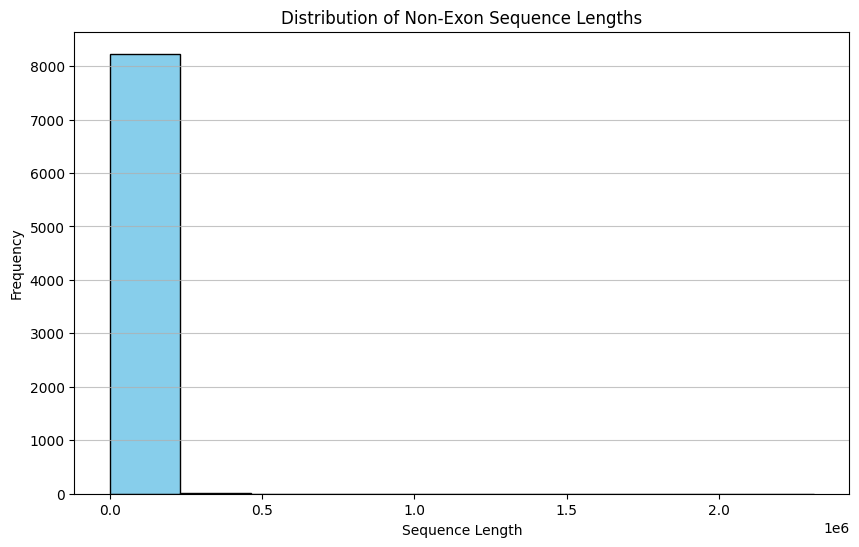

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Exon Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Showing the histogram
plt.show()

### RNN-biLSTM

In [ ]:
import torch
import torch.nn as nn

class BiLSTM_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout_rate):
        super(BiLSTM_RNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.bi_lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers,
                                batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.bi_lstm2 = nn.LSTM(input_size=2*hidden_dim, hidden_size=hidden_dim, num_layers=num_layers,
                                batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(in_features=2*hidden_dim, out_features=hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bi_lstm1(x)
        x = self.dropout(x)
        x, _ = self.bi_lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

vocab_size = 5
embedding_dim = 64
hidden_dim = 60
num_layers = 1
num_classes = 3
dropout_rate = 0.5

# Instantiate the model
model = BiLSTM_RNN(vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout_rate)
print(model)


### Codes We Save and Use Later

In [ ]:
from sklearn.utils import shuffle
non_exon_df = shuffle(non_exon_df, random_state=42)

In [ ]:
non_exon_df = non_exon_df.head(n_exon)

In [ ]:
def extract_sequence(sequence, start, end):
    return sequence[start-1:end]

# Extract non-exon sequences
non_exon_sequences = [extract_sequence(chromosome_sequence, row['start'], row['end']) for index, row in non_exon_df.iterrows()]

# Create the training dataset
training_dataset = pd.DataFrame({
    'sequence': non_exon_sequences,
    'label': ['non-exon'] * len(non_exon_sequences)
})n

In [ ]:
#helper function to parsing sequence in fasta based on gff annotation files
def extract_sequence(seqid, start, end):
    return sequence[seqid][start-1:end]

In [ ]:
dataset = []

In [ ]:
for index, row in df.iterrows():
    seqid, start, end, feature_type = row['seqid'], row['start'], row['end'], row['type']
    if seqid in sequences:  # Check if the sequence ID exists in our FASTA dictionary
        sequence = extract_sequence(seqid, start, end)
        dataset.append({'sequence': sequence, 'label': feature_type})


In [ ]:
training_dataset = pd.DataFrame(dataset)

In [ ]:
# preprocess of length of the sequence and padding if necessary
def adjust_sequence_length(sequence, head, tail, padding_char='N'):
  if len(sequence) < head:
        return None  # Sequence is too short, consider excluding it or handling separately
  elif len(sequence) > tail:
        return sequence[:tail]  # Trim to 'tail' length
  else:
        # Sequence is within range but needs padding
        padding_length = tail - len(sequence)
        return sequence + (padding_char * padding_length)

In [ ]:
# Future users: please customize the head and tail range according to your needs
adjusted_sequences = training_dataset['sequence'].apply(lambda x: adjust_sequence_length(x, head=100, tail=1000))
adjusted_sequences = adjusted_sequences.dropna()
training_dataset['adjusted_sequence'] = adjusted_sequences
training_dataset = training_dataset.dropna(subset=['adjusted_sequence']).reset_index(drop=True)

In [ ]:
# train test split (GOAL: X containing sequence data, y is the labels, eg exon, gene as specified in the gff file)
from sklearn.model_selection import train_test_split
X = training_dataset['adjusted_sequence'].apply(str)  # Ensure the sequences are in string format
y = training_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)